# **Gibbs sampler - bivariate normal distribution**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfe = tf.contrib.eager
tfe.enable_eager_execution()

C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


---
*Taken from BDA3, Chapter 11, p. 288*

Consider a single observation $(y_1, y_2)$ from a bivariate normally distributed population with unknown mean $\theta = (\theta_1, \theta_2)$ and known covariance matrix $\tiny \begin{pmatrix} 1 \; \rho \\ \rho \: 1\end{pmatrix}$. With a uniform prior distribution on $\theta$, the posterior distribution is:

$$
\begin{align}
    \begin{pmatrix}\theta_1 \\ \theta_2
    \end{pmatrix} \Big| \; y  
    &\sim \mathcal{N}\begin{pmatrix}
        \begin{pmatrix}y_1 \\ y_2 \end{pmatrix}, 
        \begin{pmatrix}1 \quad \rho \\
         \rho \quad 1
        \end{pmatrix}
    \end{pmatrix}
\end{align}
$$

Although it is simple to draw directly from the joint posterior distribution of $(\theta_1, \theta_2)$, we consider the Gibbs sampler for the purpose of exposition. To apply the Gibbs sampler to $(\theta_1, \theta_2)$, we need the conditional posterior distributions:

$$
\begin{align}
\theta_1 \mid \theta_2, y \quad &\sim \quad \mathcal{N}(y_1 + \rho(\theta_2 - y_2), 1 - \rho^2) \\
\theta_2 \mid \theta_1, y \quad &\sim \quad \mathcal{N}(y_2 + \rho(\theta_1 - y_1), 1 - \rho^2)
\end{align}
$$

---

As a toy example, let's consider $y_1 = y_2 = 0$ and $\rho=0.8$

In [2]:
# number of simulations
no_sims = 1000

# y and rho values
y = np.array([0., 0.], dtype=np.float32)
rho = 0.8
S = np.array([[1., rho], [rho, 1.]], dtype=np.float32) # covariance matrix

### "From scratch" approach

In [3]:
theta = np.empty(shape=(no_sims, 2), dtype=np.float32)

# start values of theta
theta[0, :] = np.array([0., 0.], dtype=np.float32)

for i in tqdm_notebook(range(1, no_sims)):
    # due to compability methods, enforce np.float32 (or 64) work as a workaround
    loc1 = np.float32(y[0] + rho * (theta[i-1, 1] - y[1]))
    scale1 = np.float32(1. - (rho ** 2))
    theta[i, 0] = tfd.Normal(loc1, scale1).sample()
    
    loc2 = np.float32(y[1] + rho * (theta[i, 0] - y[0]))
    scale2 = np.float32(1. - (rho ** 2))
    theta[i, 1] = tfd.Normal(loc2, scale2).sample()

C:\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:494: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.log.warn(message)
Widget Javascript not detected.  It may not be installed or enabled properly.


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


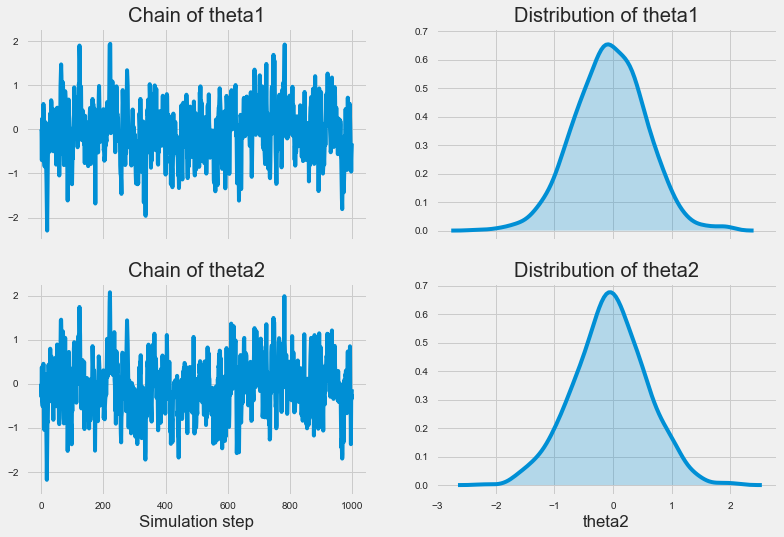

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='col')

for i in range(theta.shape[1]):
    ax[i][0].plot(theta[:, i])
    ax[i][0].set_title('Chain of theta{}'.format(i+1))
    
    sns.kdeplot(theta[:, i], ax=ax[i][1], shade=True)
    ax[i][1].set_title('Distribution of theta{}'.format(i+1))
    
ax[i][0].set_xlabel('Simulation step')
ax[i][1].set_xlabel('theta{}'.format(i+1))

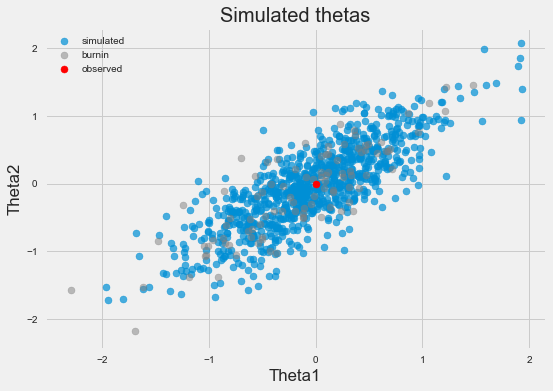

In [5]:
burnin = int(no_sims * 0.1) # 5%

plt.scatter(theta[burnin:, 0], theta[burnin:, 1], alpha=0.7, label='simulated')
plt.scatter(theta[:burnin, 0], theta[:burnin, 1], alpha=0.5, label='burnin', color='grey')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.scatter(y[0], y[1], label='observed', color='red')
plt.legend()
plt.title('Simulated thetas')

In [6]:
S_estimated = np.corrcoef(theta[:, 0], theta[:, 1])
print('empirical correlation: {:.2f} vs real one of {}'.format(S_estimated[0, 1], rho))

empirical correlation: 0.81 vs real one of 0.8


In [7]:
theta_df = pd.DataFrame(theta, columns=['theta1', 'theta2'])

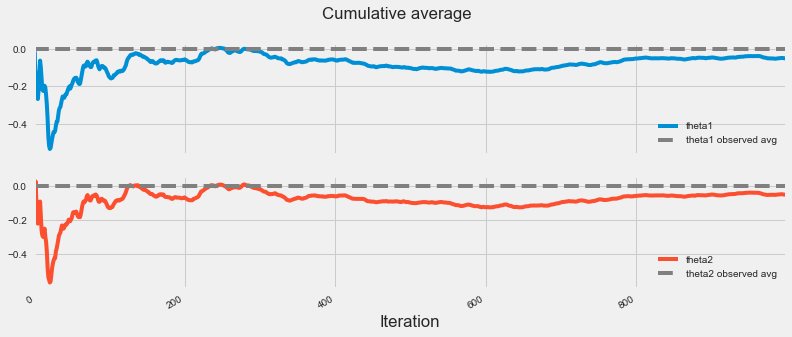

In [8]:
cum_avg = pd.DataFrame([theta_df['theta{}'.format(i+1)].cumsum() / range(1, no_sims+1) for i in range(2)]).T

ax1, ax2 = cum_avg.plot(figsize=(12, 5), title='Cumulative average', subplots=True)
ax1.axhline(y[0], label='theta1 observed avg', linestyle='dashed', color='grey')
ax1.legend()
ax2.axhline(y[1], label='theta2 observed avg', linestyle='dashed', color='grey')
ax2.legend()
ax2.set_xlabel('Iteration')

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


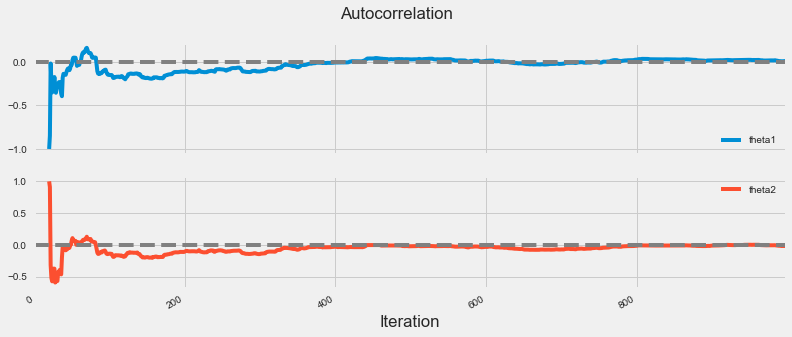

In [9]:
theta_autocorr = pd.DataFrame(
    [[theta_df.loc[:i, 'theta{}'.format(j+1)].autocorr(20) 
      for j in range(2)]
      for i in range(1, no_sims)],
    columns=['theta1', 'theta2']
)

ax1, ax2 = theta_autocorr.plot(figsize=(12, 5), title='Autocorrelation', subplots=True)
ax1.axhline(0, linestyle='dashed', color='grey')
ax2.axhline(0, linestyle='dashed', color='grey')
ax2.set_xlabel('Iteration')

#### Different observed values

In [10]:
# y 
y = np.array([-2., -1.], dtype=np.float32)

theta = np.empty(shape=(no_sims, 2), dtype=np.float32)

# start values of theta
theta[0, :] = [0., 0.]

for i in tqdm_notebook(range(1, no_sims)):
    # due to compability methods, enforce np.float32 (or 64) work as a workaround
    loc1 = np.float32(y[0] + rho * (theta[i-1, 1] - y[1]))
    scale1 = np.float32(1. - (rho ** 2))
    theta[i, 0] = tfd.Normal(loc1, scale1).sample()
    
    loc2 = np.float32(y[1] + rho * (theta[i, 0] - y[0]))
    scale2 = np.float32(1. - (rho ** 2))
    theta[i, 1] = tfd.Normal(loc2, scale2).sample()

C:\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:494: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.log.warn(message)
Widget Javascript not detected.  It may not be installed or enabled properly.


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


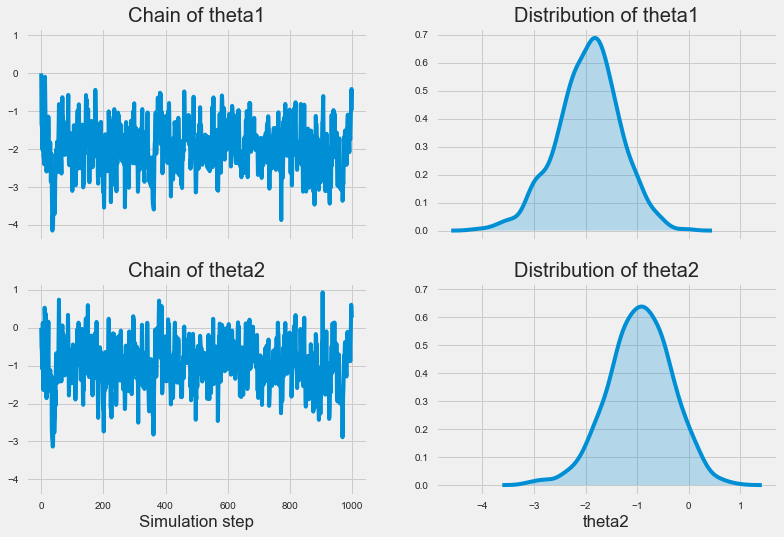

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='col')

for i in range(theta.shape[1]):
    ax[i][0].plot(theta[:, i])
    ax[i][0].set_title('Chain of theta{}'.format(i+1))
    
    sns.kdeplot(theta[:, i], ax=ax[i][1], shade=True)
    ax[i][1].set_title('Distribution of theta{}'.format(i+1))
    
ax[i][0].set_xlabel('Simulation step')
ax[i][1].set_xlabel('theta{}'.format(i+1))

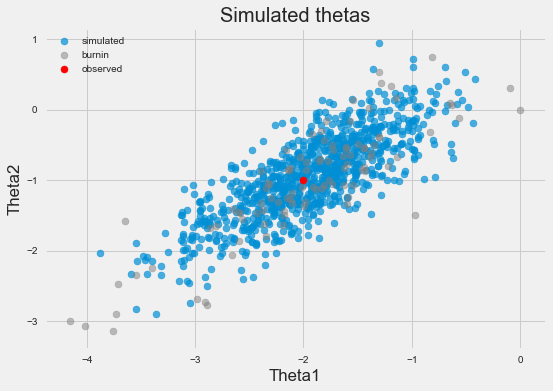

In [12]:
burnin = int(no_sims * 0.1) # 5%

plt.scatter(theta[burnin:, 0], theta[burnin:, 1], alpha=0.7, label='simulated')
plt.scatter(theta[:burnin, 0], theta[:burnin, 1], alpha=0.5, label='burnin', color='grey')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.scatter(y[0], y[1], label='observed', color='red')
plt.legend()
plt.title('Simulated thetas')

In [13]:
S_estimated = np.corrcoef(theta[:, 0], theta[:, 1])
print('empirical correlation: {:.2f} vs real one of {}'.format(S_estimated[0, 1], rho))

empirical correlation: 0.80 vs real one of 0.8


**Different observed values**

In [14]:
# y 
y = np.array([-2., -1.], dtype=np.float32)

theta = np.empty(shape=(no_sims, 2), dtype=np.float32)

# start values of theta
theta[0, :] = [0., 0.]

for i in tqdm_notebook(range(1, no_sims)):
    # due to compability methods, enforce np.float32 (or 64) work as a workaround
    loc1 = np.float32(y[0] + rho * (theta[i-1, 1] - y[1]))
    scale1 = np.float32(1. - (rho ** 2))
    theta[i, 0] = tfd.Normal(loc1, scale1).sample()
    
    loc2 = np.float32(y[1] + rho * (theta[i, 0] - y[0]))
    scale2 = np.float32(1. - (rho ** 2))
    theta[i, 1] = tfd.Normal(loc2, scale2).sample()

C:\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:494: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.log.warn(message)
Widget Javascript not detected.  It may not be installed or enabled properly.


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


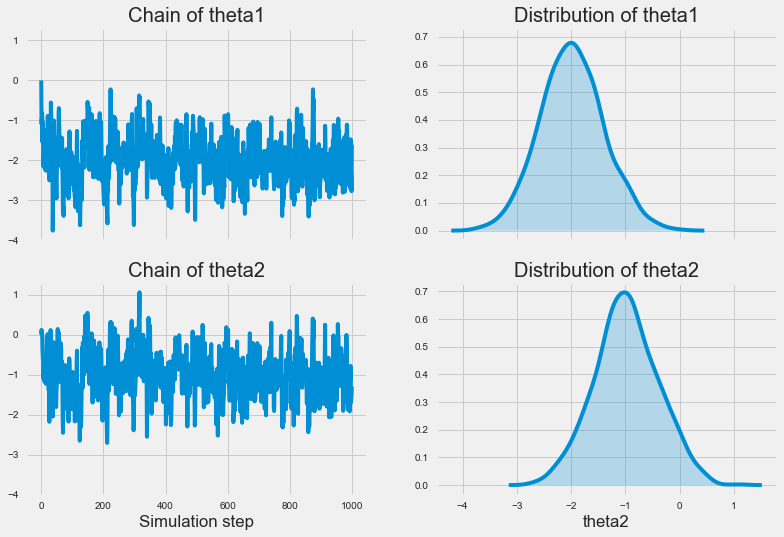

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='col')

for i in range(theta.shape[1]):
    ax[i][0].plot(theta[:, i])
    ax[i][0].set_title('Chain of theta{}'.format(i+1))
    
    sns.kdeplot(theta[:, i], ax=ax[i][1], shade=True)
    ax[i][1].set_title('Distribution of theta{}'.format(i+1))
    
ax[i][0].set_xlabel('Simulation step')
ax[i][1].set_xlabel('theta{}'.format(i+1))

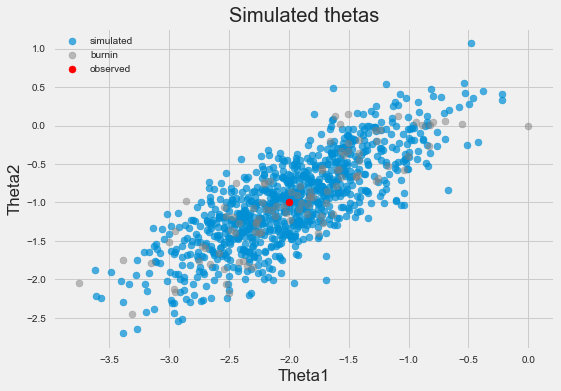

In [16]:
burnin = int(no_sims * 0.1) # 5%

plt.scatter(theta[burnin:, 0], theta[burnin:, 1], alpha=0.7, label='simulated')
plt.scatter(theta[:burnin, 0], theta[:burnin, 1], alpha=0.5, label='burnin', color='grey')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.scatter(y[0], y[1], label='observed', color='red')
plt.legend()
plt.title('Simulated thetas')

In [17]:
S_estimated = np.corrcoef(theta[:, 0], theta[:, 1])
print('empirical correlation: {:.2f} vs real one of {}'.format(S_estimated[0, 1], rho))

empirical correlation: 0.80 vs real one of 0.8


In [18]:
theta_df = pd.DataFrame(theta, columns=['theta1', 'theta2'])

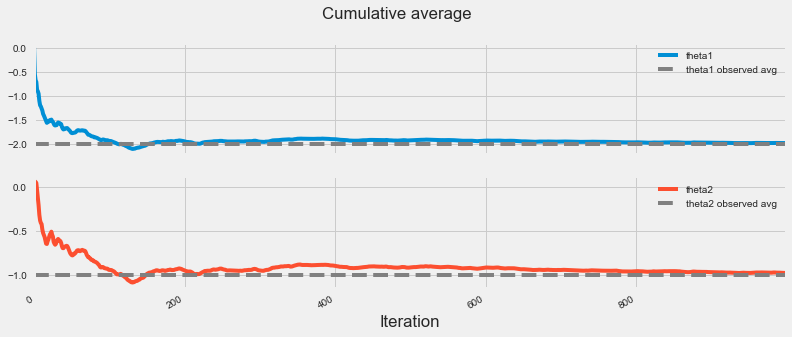

In [19]:
cum_avg = pd.DataFrame([theta_df['theta{}'.format(i+1)].cumsum() / range(1, no_sims+1) for i in range(2)]).T

ax1, ax2 = cum_avg.plot(figsize=(12, 5), title='Cumulative average', subplots=True)
ax1.axhline(y[0], label='theta1 observed avg', linestyle='dashed', color='grey')
ax1.legend()
ax2.axhline(y[1], label='theta2 observed avg', linestyle='dashed', color='grey')
ax2.legend()
ax2.set_xlabel('Iteration')

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


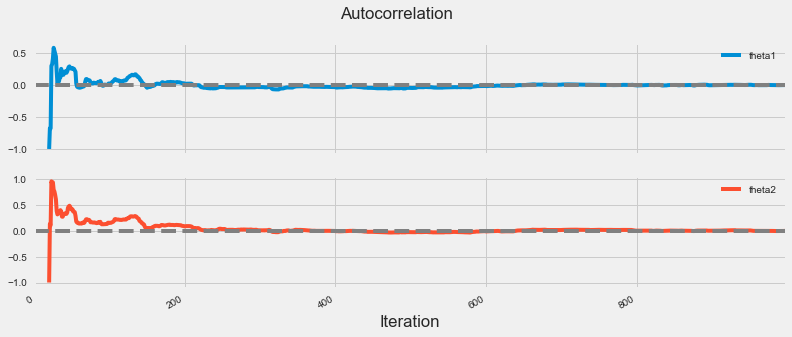

In [20]:
theta_autocorr = pd.DataFrame(
    [[theta_df.loc[:i, 'theta{}'.format(j+1)].autocorr(20) 
      for j in range(2)]
      for i in range(1, no_sims)],
    columns=['theta1', 'theta2']
)

ax1, ax2 = theta_autocorr.plot(figsize=(12, 5), title='Autocorrelation', subplots=True)
ax1.axhline(0, linestyle='dashed', color='grey')
ax2.axhline(0, linestyle='dashed', color='grey')
ax2.set_xlabel('Iteration')

#### Different starting values

In [21]:
# y 
y = np.array([0., 0.], dtype=np.float32)

theta = np.empty(shape=(no_sims, 2), dtype=np.float32)

# start values of theta
theta[0, :] = [-2., 3.]

for i in tqdm_notebook(range(1, no_sims)):
    # due to compability methods, enforce np.float32 (or 64) work as a workaround
    loc1 = np.float32(y[0] + rho * (theta[i-1, 1] - y[1]))
    scale1 = np.float32(1. - (rho ** 2))
    theta[i, 0] = tfd.Normal(loc1, scale1).sample()
    
    loc2 = np.float32(y[1] + rho * (theta[i, 0] - y[0]))
    scale2 = np.float32(1. - (rho ** 2))
    theta[i, 1] = tfd.Normal(loc2, scale2).sample()

C:\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:494: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.log.warn(message)
Widget Javascript not detected.  It may not be installed or enabled properly.


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


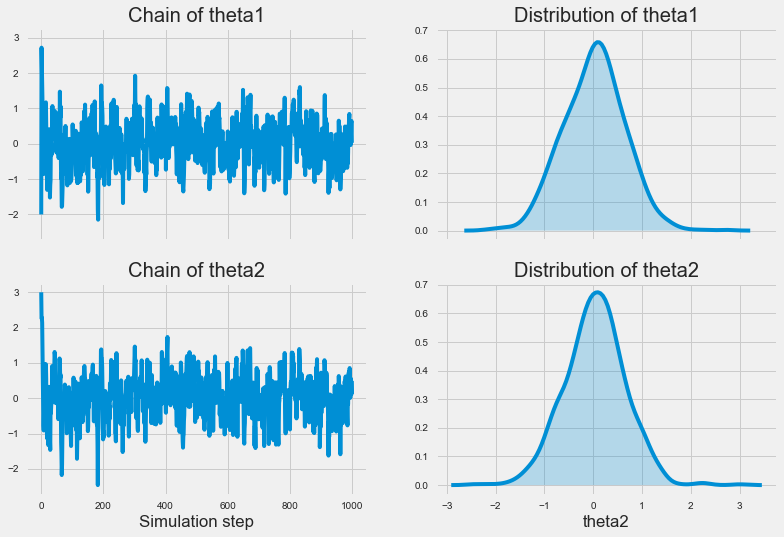

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='col')

for i in range(theta.shape[1]):
    ax[i][0].plot(theta[:, i])
    ax[i][0].set_title('Chain of theta{}'.format(i+1))
    
    sns.kdeplot(theta[:, i], ax=ax[i][1], shade=True)
    ax[i][1].set_title('Distribution of theta{}'.format(i+1))
    
ax[i][0].set_xlabel('Simulation step')
ax[i][1].set_xlabel('theta{}'.format(i+1))

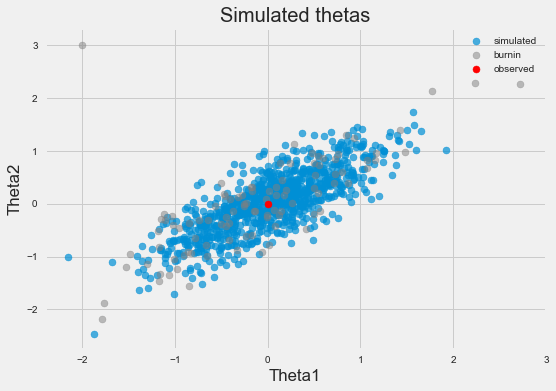

In [23]:
burnin = int(no_sims * 0.1) # 5%

plt.scatter(theta[burnin:, 0], theta[burnin:, 1], alpha=0.7, label='simulated')
plt.scatter(theta[:burnin, 0], theta[:burnin, 1], alpha=0.5, label='burnin', color='grey')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.scatter(y[0], y[1], label='observed', color='red')
plt.legend()
plt.title('Simulated thetas')

In [24]:
S_estimated = np.corrcoef(theta[:, 0], theta[:, 1])
print('empirical correlation: {:.2f} vs real one of {}'.format(S_estimated[0, 1], rho))

empirical correlation: 0.78 vs real one of 0.8


In [25]:
theta_df = pd.DataFrame(theta, columns=['theta1', 'theta2'])

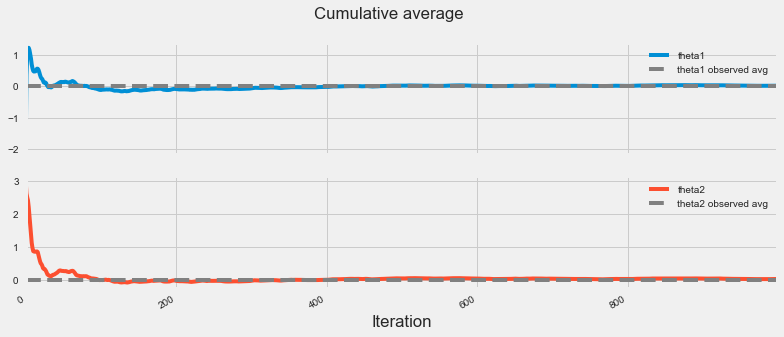

In [26]:
cum_avg = pd.DataFrame([theta_df['theta{}'.format(i+1)].cumsum() / range(1, no_sims+1) for i in range(2)]).T

ax1, ax2 = cum_avg.plot(figsize=(12, 5), title='Cumulative average', subplots=True)
ax1.axhline(y[0], label='theta1 observed avg', linestyle='dashed', color='grey')
ax1.legend()
ax2.axhline(y[1], label='theta2 observed avg', linestyle='dashed', color='grey')
ax2.legend()
ax2.set_xlabel('Iteration')

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


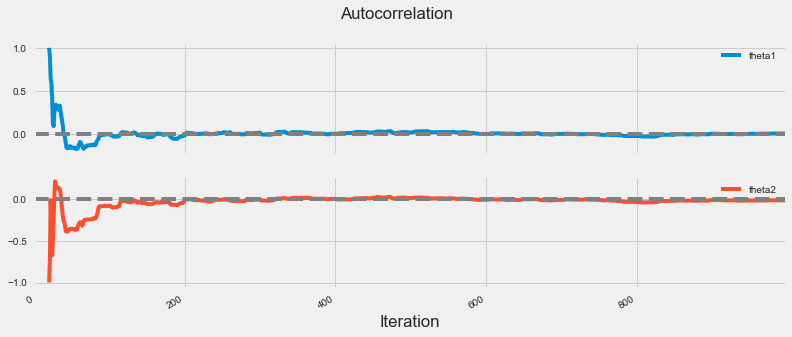

In [27]:
theta_autocorr = pd.DataFrame(
    [[theta_df.loc[:i, 'theta{}'.format(j+1)].autocorr(20) 
      for j in range(2)]
      for i in range(1, no_sims)],
    columns=['theta1', 'theta2']
)

ax1, ax2 = theta_autocorr.plot(figsize=(12, 5), title='Autocorrelation', subplots=True)
ax1.axhline(0, linestyle='dashed', color='grey')
ax2.axhline(0, linestyle='dashed', color='grey')
ax2.set_xlabel('Iteration')